# MLP for MNIST Digit Recognition

In [563]:
import torch
import torch.nn.functional as F

In [564]:
from torchvision import datasets, transforms

In [565]:
g = torch.Generator().manual_seed(2147483647)

In [566]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [567]:
trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform);

In [568]:
import matplotlib.pyplot as plt

In [569]:
trainset[1][1]

0

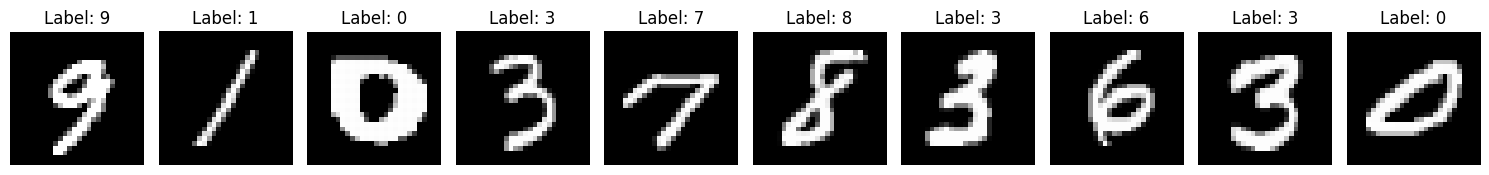

In [698]:
plt.figure(figsize=(15, 3))

plots = 10
ix = torch.randint(len(trainset), (plots,))
sam = torch.utils.data.Subset(trainset, ix)
i=0

for image, label in sam:
    plt.subplot(1, plots, i + 1)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f"Label: {label}")
    plt.axis('off')
    i += 1

plt.tight_layout()
plt.show()

In [571]:
Xtrain = trainset.data.view(-1, 28*28) / 255.0
Ytrain = trainset.targets

In [572]:
Xtrain.shape, Ytrain.shape

(torch.Size([60000, 784]), torch.Size([60000]))

#### Parameter Initialization
1 Hidden Layer (784x32), 1 BatchNorm Layer (2x32), 1 Output Layer (32x10) - 25k params

In [688]:
hidden_size = 32

W1 = torch.randn(28*28, hidden_size) * ((2/1.0001)/784)**0.5
W2 = torch.randn(hidden_size, 10) * 0.1
b2 = torch.zeros(10)

bngain = torch.ones((1, hidden_size))
bnbias = torch.zeros((1, hidden_size))


params = [W1, bngain, bnbias, W2, b2]
print(sum(p.nelement() for p in params))
for p in params:
  p.requires_grad = True

25482


In [689]:
for p in params:
    print(p.shape)

torch.Size([784, 32])
torch.Size([1, 32])
torch.Size([1, 32])
torch.Size([32, 10])
torch.Size([10])


In [690]:
steps = 50000
batch_size = 32
losses = []

with torch.no_grad():
    for i in range(steps):

        batchi = torch.randint(0, Xtrain.shape[0], (batch_size,))
        Xb, Yb = Xtrain[batchi], Ytrain[batchi] # (32, 784), (32,)
        # Forward pass
        hprebn = Xb @ W1 #(32 x 784) x (784 x 32) -> (32 x 128)
        bnmean = hprebn.mean(0, keepdim=True)
        bnvar = hprebn.var(0, keepdim=True, unbiased=True)
        bnvar_inv = (bnvar + 1e-5)**-0.5
        bnraw = (hprebn - bnmean) * bnvar_inv
        hpreact = bngain * bnraw + bnbias

        h = F.leaky_relu(hpreact) # (32 x 128)

        logits = h @ W2 + b2 # (32 x 32) x (32 x 10) -> (32 x 10)

        # Loss
        loss = F.cross_entropy(logits, Yb)
        # logit_maxes = logits.max(1, keepdim=True).values # (32 x 1)
        # norm_logits = logits - logit_maxes # (32 x 10)
        # counts = norm_logits.exp() # (32 x 10)
        # counts_sum = counts.sum(1, keepdims=True) # (32 x 1)
        # counts_sum_inv = counts_sum**-1 # (32 x 1)
        # probs = counts * counts_sum_inv # (32 x 10)
        # logprobs = probs.log() # (32 x 10)
        # loss = -logprobs[range(batch_size), Yb].mean() # (1)

        dlogits = F.softmax(logits, 1)
        dlogits[range(batch_size), Yb] -= 1
        dlogits /= batch_size

        dh = dlogits @ W2.T
        dW2 = h.T @ dlogits
        db2 = dlogits.sum(0)

        dhpreact = h/hpreact
        dhpreact = dhpreact.masked_fill(torch.isnan(dhpreact), 1.0) * dh
        dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
        dbnbias = dhpreact.sum(0, keepdim=True)
        dhprebn = bngain * bnraw*(dhpreact - (1/batch_size)*dhpreact.sum(0) - (bnraw/(batch_size-1))*(dhpreact * bnraw).sum(0))

        dW1 = Xb.T @ dhprebn

        grads = [dW1, dbngain, dbnbias, dW2, db2]

        for p in params:
            p.grad = None
        #loss.backward()

        # update
        lr = 0.1 if i < 40000 else 0.01
        for p, grad in zip(params, grads):
            # p.data += -lr * p.grad
            p.data += -lr * grad
        
        if i % 10000 == 0:
            print(f'{i:7d}/{steps:7d}: {loss.item():.4f}')
        losses.append(loss.log10().item())
        
    print(f'{steps:7d}/{steps:7d}: {loss.item():.4f}')

      0/  50000: 2.3669
  10000/  50000: 0.0874
  20000/  50000: 0.0535
  30000/  50000: 0.1473
  40000/  50000: 0.0220
  50000/  50000: 0.1228


In [ ]:
dlogits = F.softmax(logits, 1)
dlogits[range(batch_size), Yb] -= 1
dlogits /= batch_size

dh = dlogits @ W2.T
dW2 = h.T @ dlogits
db2 = dlogits.sum(0)

dhpreact = h/hpreact * dh
dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
dbnbias = dhpreact.sum(0, keepdim=True)
dhprebn = bngain * bnraw*(dhpreact - (1/batch_size)*dhpreact.sum(0) - (bnraw/(batch_size-1))*(dhpreact * bnraw).sum(0))

dW1 = Xb.T @ dhprebn
grads = [dW1, dbngain, dbnbias, dW2, db2]
for g in grads:
    print(g.shape)

torch.Size([784, 128])
torch.Size([1, 128])
torch.Size([1, 128])
torch.Size([128, 10])
torch.Size([10])


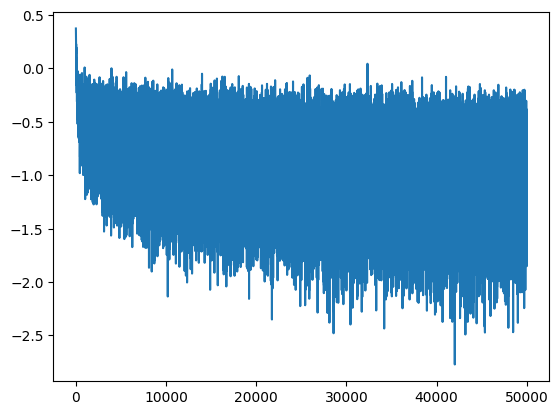

In [691]:
plt.plot(losses)

In [577]:
losses[-1]

-3.325838327407837

In [578]:
testset = datasets.MNIST(root='./data', train=False, download=False, transform=transform);

In [587]:
Xtest = testset.data.view(-1, 28*28) / 255.0 
Ytest = testset.targets

(-0.5, 27.5, 27.5, -0.5)

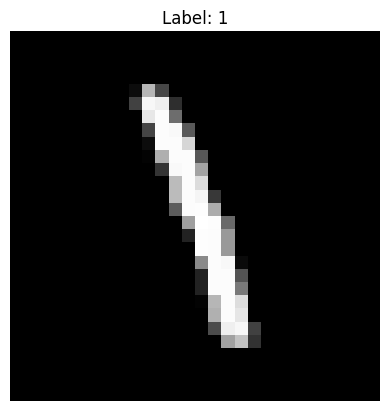

In [693]:
im_index = 191
image = Xtest[im_index].view(28, 28)
plt.imshow(image, cmap='gray')
plt.title(f'Label: {Ytest[im_index]}')
plt.axis('off')

In [694]:
with torch.no_grad():
    # Forward pass
    bruh = Xtrain @ W1
    bnmean_tot = bruh.mean(0, keepdim=True)
    bnstdi_tot = bruh.std(0, keepdim=True)


In [581]:
bnstdi_tot.shape, bnmean_tot.shape

(torch.Size([1, 128]), torch.Size([1, 128]))

In [695]:
def predict(im):
    with torch.no_grad():
        prebn = im.view(1, -1) @ W1
        preact = bngain * (prebn - bnmean_tot) / bnstdi_tot + bnbias
        hs = F.leaky_relu(preact)
        scores = hs @ W2 + b2
    return torch.argmax(scores, dim=1).item()

In [696]:
predict(image)

1

In [697]:
plt.figure(figsize=(15, 3));
plotting = False
r = len(Xtest)
wrong = 0
predicted = {}
for i in range(r):
    if plotting: plt.subplot(1, r, i + 1)
    digit = Xtest[i].view(-1)
    label = Ytest[i]
    if plotting: plt.imshow(digit.view(28, 28), cmap='gray')
    pred = predict(digit)
    if plotting: plt.title(f"Label: {label}\nPred: {pred}")
    if plotting: plt.axis('off')
    if (pred != label):
        wrong += 1
    if pred not in predicted:
        predicted[pred] = 0
    else:
        predicted[pred] += 1
(1 - wrong/r) * 100

96.65

<Figure size 1500x300 with 0 Axes>

### 96.65% accuracy on unseen test data